【台北大學碩士班課程】淺度機器學習<br>
【授課老師】汪群超<br>
【學期】1112 <br>
【主要內容】SVD 在影像上的應用（壓縮、解密）<br>
【作者】711133117 陳怡升 <br>
【參考網站】[汪群超 Shallow Machine Learning Lesson 6 : PCA 、SVD 及其在影像處理的應用](https://ntpuccw.blog/python-in-learning/sml%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9apca-%e3%80%81svd-%e5%8f%8a%e5%85%b6%e5%9c%a8%e5%bd%b1%e5%83%8f%e8%99%95%e7%90%86%e7%9a%84%e6%87%89%e7%94%a8/)

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.linalg import svd
import cv2, glob

In [2]:
imgfile = r'C:\Course\1112ShallowMachineLearning\data'

# 上課理論整理
在著手於寫程式之前，要先理解自己到底在寫甚麼，因此使用一些篇幅來整理本次作業的理論基礎。
## SVD理論

奇異值分解（Singular value decomposition，縮寫為 SVD）是線性代數中時常被使用到的工具，其原理可以想成是一種矩陣的因式分解。它可以應用在許多地方，像是和 PCA（Principal Component Analysis）一樣對資料進行維度縮減、對影像進行壓縮，也可以應用在 Netflix、Amazon 各大網站的推薦系統上。SVD 之所以這麼廣泛的被應用，主要是因為它可以應用在各式各樣的矩陣上，並且原理很簡單又非常好解釋，下面將帶讀者了解 SVD 的矩陣拆解。

$\mathbf{X}$ 為任意一個 $p\times n$ 的矩陣，$p$ 為特徵數，$n$ 為樣本數，則存在一個分解使得：

\begin{align}
\mathbf{X}=\mathbf{U}\mathbf{\Sigma}\mathbf{V^T}=\sum^{r}_{k=1}\sigma_k\mathbf{u}_k\mathbf{v}^T_k,\;\; \sigma_1 > \sigma_2 > \ldots > \sigma_p
\end{align}

其中 $\mathbf{U}$ 和 $\mathbf{V}$ 皆為正交（orthogonal）的方陣，只是兩者的維度不相同，$\mathbf{U}$ 是 $p\times p$ 的矩陣，在 $p$ 度空間中互相獨立，$\mathbf{V}$ 則是在 $n$ 度空間中互相獨立的 $n\times n$ 矩陣，而 $r=Rank(\mathbf{X})\leq \min(n,p)$ ，最後 $\Sigma$ 為 $p \times n$ 的對角矩陣，其形態如下所示：

\begin{equation}
\mathbf{\Sigma} = \begin{bmatrix}
\sigma_1 & 0 & 0 & 0 & \cdots & 0\\
0 & \ddots & 0 & \vdots & \ddots & \vdots\\
0 & 0 & \sigma_r & 0 & \cdots & 0\\
0 & \cdots & 0 & 0 & \cdots & 0\\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots\\
0 & \cdots & 0 & 0 & \cdots & 0\\
\end{bmatrix}_{p\times n}
\end{equation}

$\sigma$ 就是主對角線的值，也稱之為奇異值（singular value），為了應用方便，通常習慣將 $\sigma$ 由大至小排序，而上述的 $\mathbf{U}$ 和 $\mathbf{V}$ 就是奇異向量（singular vector），可以想像成特徵值與特徵向量。下圖為 SVD 的矩陣結構，透過下圖可以更了解矩陣如何被拆解。後續將詳細介紹經常與SVD搭配使用的Rank q approximation。

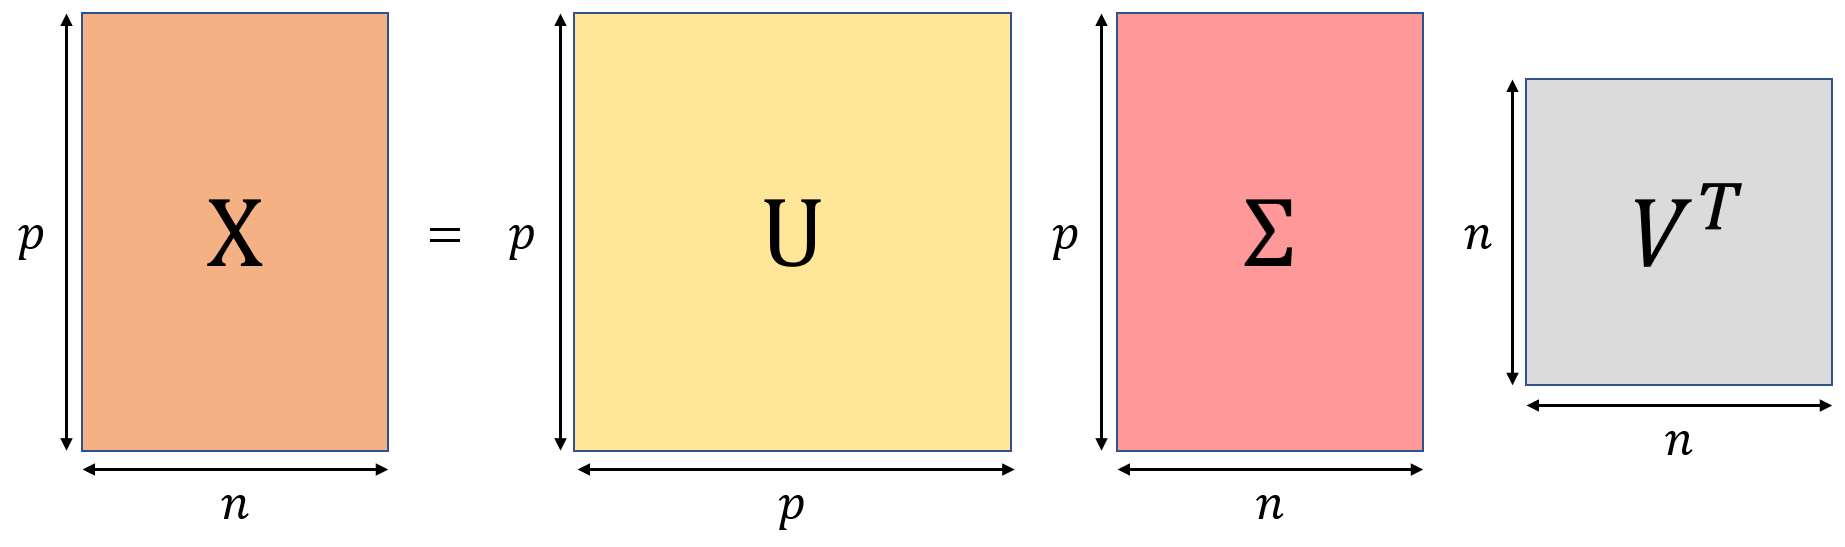

## Rank q approximation：從 p 度空間降為降到 q 度空間

Rank q approximation 簡單來說就是取前 $q$ 個貢獻度較高的奇異值與奇異向量，降低不必要資訊的儲存空間，也可以把上述 SVD 的示意圖改寫為下圖所示：
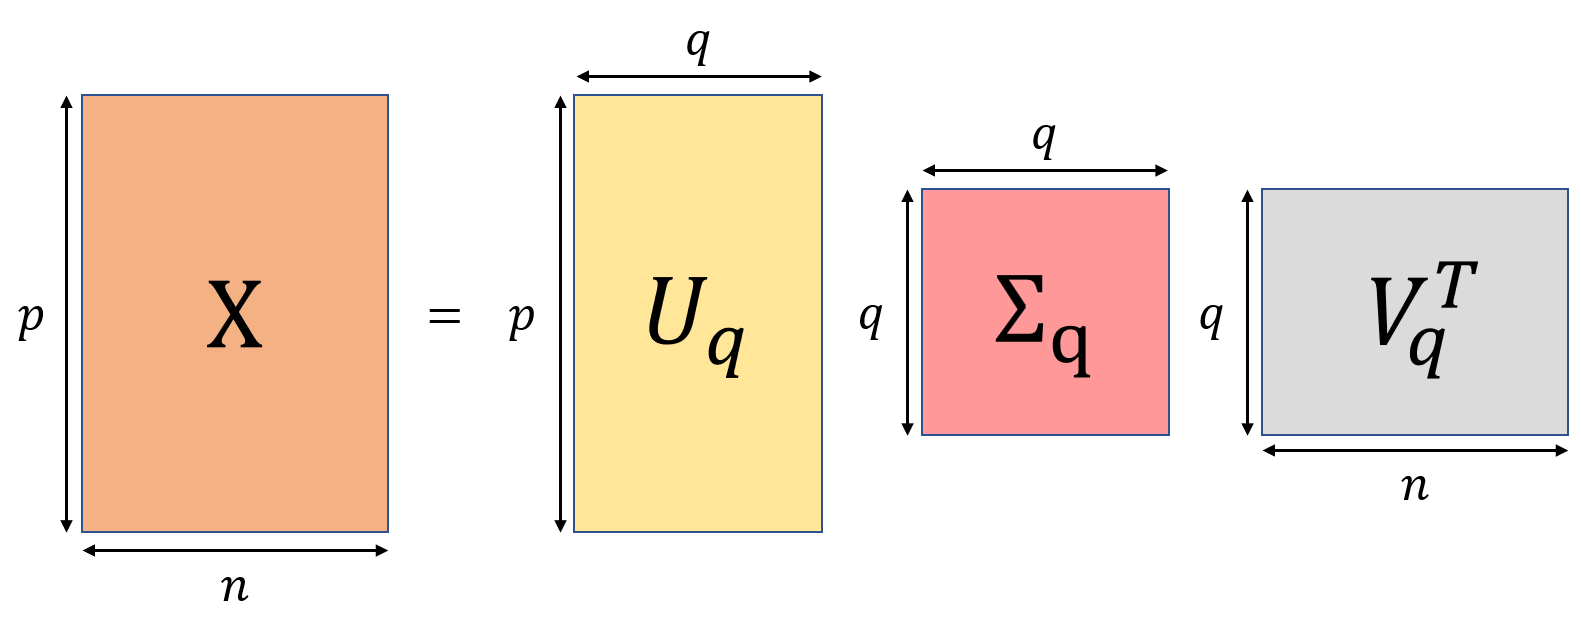

套用到影像壓縮的例子，若可以儲存重要的成分，就可以壓縮影像的儲存空間，也就是儲存$\mathbf{U_q}$、$\Sigma_q$、$\mathbf{V_q}$ 與原始圖片 $p\times n$ 個像素的差異，以下將帶來 SVD 與 Rank q approximation 的實際應用，分別會包含影像的壓縮、主成分的解析以及加密解密的應用。

# 習題 1：影像壓縮

做阿富汗女孩和Lenna
將一張圖像 X 利用 SVD 的 Rank q approximation，能達到壓縮的目的並保持圖像的品質。比較下列幾種對於圖像矩陣 X 的重組安排，並進行 Rank q approximation，在同樣的壓縮比之下，觀察還原後的圖像品質哪個最好？能說出理由嗎？

1. X 不變

2. 將 X 以 $8\times 8$ 小圖（patch）進行切割，再將每個小圖拉成 $64\times 1$ 的向量，最後重組這些向量並排成新的 $64\times N$ 矩陣。

3. 同上，小圖大小為 $16\times 16$/per patch。

4. 同上，但分割成 $32\times 32$/per patch。

本次作業將針對 Lenna 以及阿富汗女孩的圖像進行探討，由於要比較不同小圖的影響，將會固定壓縮比例去進行比較，根據 Rank q approximation 的介紹，壓縮比例（Compression Ratio）的計算公式為 $\frac{p* n}{p*q +q + q*n}$，在此假設原本圖片的大小為 $p\times n$。

## 阿富汗女孩
首先將針對阿富汗女孩的影像進行分析。
### 原始影像
下圖為阿富汗女孩的原始灰階影像，從影像中可以看出此影像對比明顯，人臉與背景顏色差距較大且同一區塊的顏色接近。

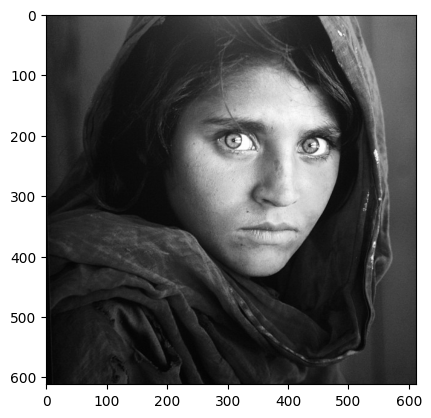

In [3]:
img = cv2.imread(imgfile + r'\green-eye-afghan-girl-national-geographic.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

### X 不變執行 SVD 與 Rank q approximation
從最簡單的 $\mathbf{X}$ 不改變開始，執行 SVD 後再用 Rank q approximation 擷取特徵，壓縮儲存的資料。

In [4]:
X = img
U, S, VT = np.linalg.svd(X, full_matrices = True)
S = np.diag(S)
p, n = X.shape
new_img_dict_orig = {}
compress = [8, 16, 32, 64, 128]
for c in compress:
    q = int(np.round((p*n-c)/(c*(p+n)),0))
    new_img_dict_orig[c] = U[:,:q] @ S[:q,:q] @ VT[:q,:]

In [5]:
def compress_image(lenna_img, pn, compress):
    y, x = lenna_img.shape
    p = int(y*x/(pn*pn)); n = pn*pn
    X = np.zeros([int(y*x/(pn*pn)), pn*pn])
    for i in range(0,y//pn):
        for j in range(0,x//pn):
            X[(y//pn)*i+j,:] = lenna_img[pn*i:pn*(i+1),pn*j:pn*(j+1)].reshape((1,-1))
    U, S, VT = np.linalg.svd(X, full_matrices = True)
    S = np.diag(S)
    new_img_dict = {}
    for c in compress:
        q = int(np.round((x*y)/(c*(p+n+1)),0))
        X_q = U[:,:q] @ S[:q,:q] @ VT[:q,:]
        tmparray = np.zeros((y, x))
        for r in range(0,X_q.shape[0]):
            i = r//(y//pn); j = r%(y//pn)
            tmparray[pn*i:pn*(i+1),pn*j:pn*(j+1)] = X_q[r,:].reshape(pn,pn)
        new_img_dict[c] = tmparray
    return new_img_dict

### 切割成不同大小的小圖（patch）
將 $\mathbf{X}$ 以 $n_p\times n_p$ 小圖（patch）進行切割，再將每個小圖拉成 $1 \times n_p^2$ 的向量，重組這些向量並排成新的 $N\times n_p^2$ 矩陣，最後使用新的矩陣進行 SVD 。

1. $9\times 9$
3. $18\times 18$
4. $36\times 36$

由於 $\mathbf{X}$ 維度改變，在此壓縮比率的計算公式如下所示：
\begin{equation}\frac{p* n}{N*q + q + q*n_p^2}\end{equation}

下圖是不同切割方式在相異壓縮率的比較，X 軸分別是不同壓縮率，而 Y 軸則是不同的切割方式及大小。從此圖可以觀察到壓縮率至 16 倍前都沒有太大的差異，從 32 倍開始就可以觀察到原始圖片與切割過的差異，而 64 倍之後則看到 $n_p$ 對壓縮的影響，隨著壓縮率越大，用小圖切割的表現就比原始圖片優秀許多，並且可以觀察到隨著 $n_p$ 增加其壓縮表現也會降低。

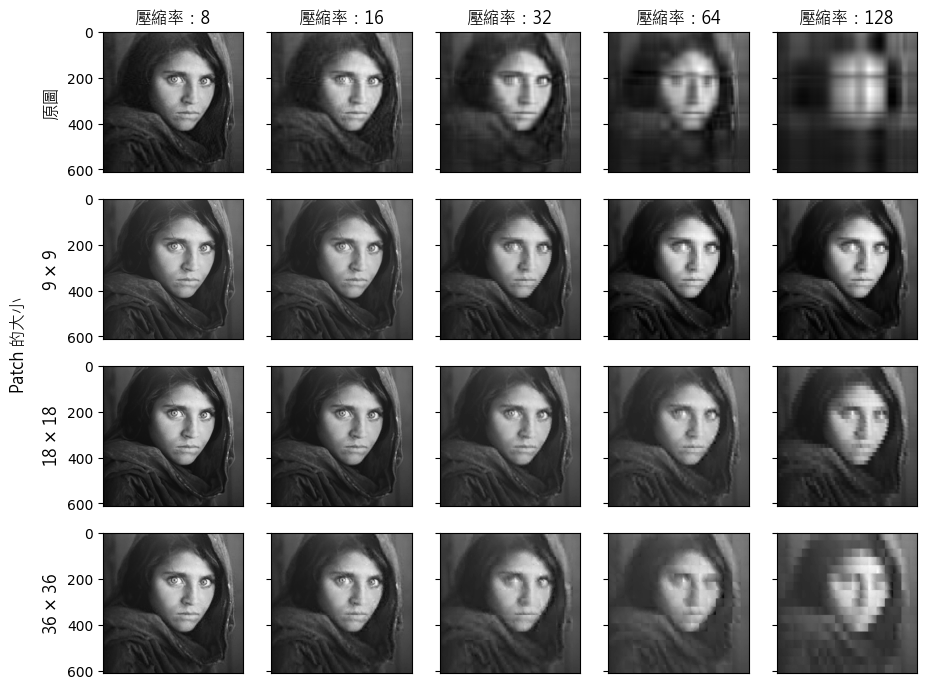

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=len(new_img_dict_orig.keys()), sharex=True, sharey=True, figsize=(9.5,7))
for pn_e, pn in enumerate([1, 9, 18, 36]):
    new_img_dict = {}
    if pn == 1:
        new_img_dict = new_img_dict_orig
    else:
        new_img_dict = compress_image(img, pn, compress)
    for e, c in enumerate(new_img_dict_orig.keys()):
        ax[pn_e, e].imshow(new_img_dict.get(c), cmap=plt.cm.gray)
        if pn_e == 0:
            ax[pn_e, e].set_title("壓縮率：{}".format(c), fontname="Microsoft JhengHei", fontsize=12)
        ax[pn_e, e].get_xaxis().set_visible(False)
        if e == 0:
            if pn==1:
                ylabel = '原圖'
            else:
                ylabel = r'{} $\times$ {}'.format(pn,pn)
            ax[pn_e, e].set_ylabel(ylabel, fontname="Microsoft JhengHei", fontsize=12)
fig.supylabel('Patch 的大小', fontname="Microsoft JhengHei")
plt.tight_layout()
plt.show()

## Lenna

接著將針對 Lenna 進行討論。
### 原始影像
原始的灰階影像如下所示，由於 Lenna 的影像構成比較複雜，其灰階影像中人臉與背景並沒有強烈的對比且顏色混雜在各個區塊中，因此並不是非常好處理的例子。

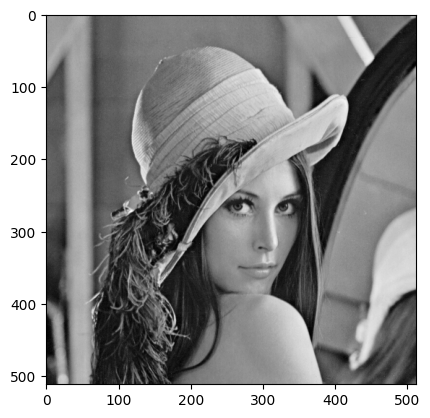

In [7]:
lenna_img = cv2.imread(imgfile + r'\lenna.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(lenna_img, cmap=plt.cm.gray)
plt.show()

### X 不變執行 SVD 與 Rank q approximation
從最簡單的 $\mathbf{X}$ 不改變開始，執行 SVD 後再用 Rank q approximation 擷取特徵，壓縮儲存的資料。

In [8]:
X = lenna_img
U, S, VT = np.linalg.svd(X, full_matrices = True)
S = np.diag(S)
p, n = X.shape
new_img_dict_orig = {}
compress = [4,8,16,32,64]
for c in compress:
    q = int(np.round(n*p/(c*(p+n+1)),0))
    new_img_dict_orig[c] = U[:,:q] @ S[:q,:q] @ VT[:q,:]

### 切割成不同大小的小圖（patch）
將 $\mathbf{X}$ 以 $n_p\times n_p$ 小圖（patch）進行切割，再將每個小圖拉成 $1 \times n_p^2$ 的向量，重組這些向量並排成新的 $N\times n_p^2$ 矩陣，最後使用新的矩陣進行 SVD 。

1. $8\times 8$
3. $16\times 16$
4. $32\times 32$

由於 $\mathbf{X}$ 維度改變，在此壓縮比率的計算公式如下所示：
\begin{equation}\frac{p* n}{N*q + q + q*n_p^2}\end{equation}

下圖是不同切割方式在相異壓縮率的比較，X 軸分別是不同壓縮率，而 Y 軸則是不同的切割方式及大小。從此圖可以發現到壓縮率至 8 倍前都沒有太大的差異，從 8 倍開始就可以觀察到原始圖片與切割過的差異，而 32 倍之後則看到 $n_p$ 對壓縮的影響。隨著壓縮率越大，有切割過的圖片比原始圖片的表現優秀許多，並且可以觀察到隨著 $n_p$ 增加其壓縮表現也會降低。

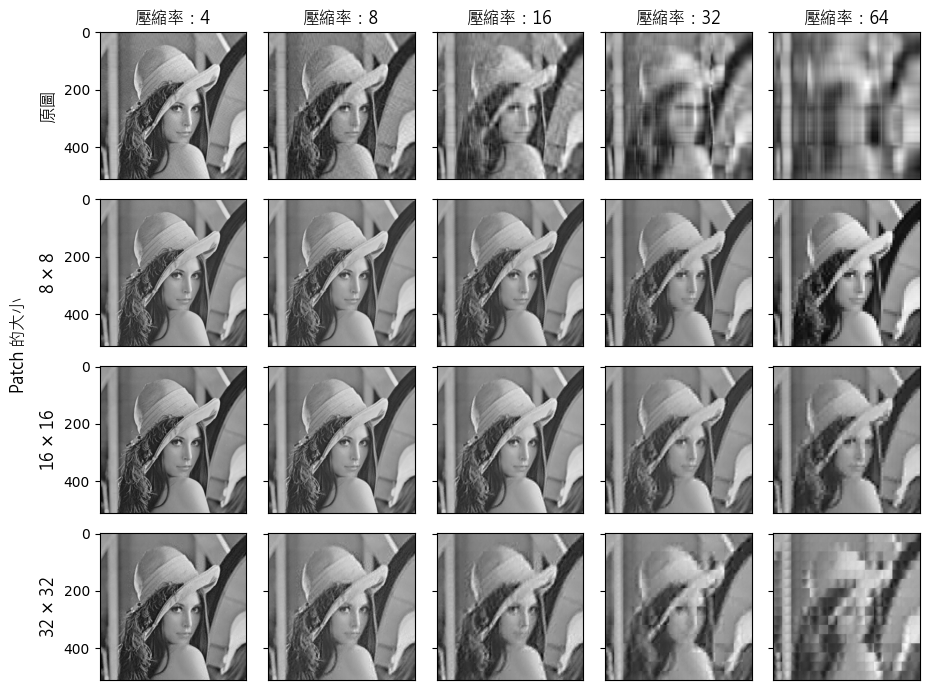

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=len(new_img_dict_orig.keys()), sharex=True, sharey=True, figsize=(9.5,7))
for pn_e, pn in enumerate([1, 8 ,16 ,32]):
    new_img_dict = {}
    if pn == 1:
        new_img_dict = new_img_dict_orig
    else:
        new_img_dict = compress_image(lenna_img, pn, compress=[4,8,16,32,64])
    for e, c in enumerate(new_img_dict_orig.keys()):
        ax[pn_e, e].imshow(new_img_dict.get(c), cmap=plt.cm.gray)
        if pn_e == 0:
            ax[pn_e, e].set_title("壓縮率：{}".format(c), fontname="Microsoft JhengHei", fontsize=12)
        ax[pn_e, e].get_xaxis().set_visible(False)
        if e == 0:
            if pn==1:
                ylabel = '原圖'
            else:
                ylabel = r'{} $\times$ {}'.format(pn,pn)
            ax[pn_e, e].set_ylabel(ylabel, fontname="Microsoft JhengHei", fontsize=12)
fig.supylabel('Patch 的大小', fontname="Microsoft JhengHei")
plt.tight_layout()
plt.show()

## 總結
從上述兩張影像皆可發現：
- 使用小圖切割比原始圖片表現更好
-  $n_p$ 增加，壓縮表現會降低

至於為甚麼會有這樣的結果呢？本人猜測是因為小圖之間的顏色較相近，因此在進行SVD時會有比較好的矩陣拆解，也可以用更少的 q 擷取到更多有用的資訊。這點也可以由上述兩張圖片的差異來驗證，顏色較複雜的 lenna 在壓縮率為 16 倍就可以觀察出原圖與其它的差異，而顏色較單純的阿富汗女孩則是要到 32 倍或 64 倍才開始明顯觀察出原圖與其它的差異。因此顏色複雜度在影像壓縮當中應該也是蠻重要的一環。

# 習題 2：Montage
處理大量影像前，有必要觀看影像圖，以確定能掌握將要處理的影像及其資料型態。

以 70000 張手寫圖像為例，每個數字約 7000 字，需要寫一段程式碼來觀察這些手寫數字的影像與品質，且每次執行都能隨機觀看到不同的影像。

In [13]:
df = pd.read_csv(imgfile + r'\mnist_number.csv')
X = df.copy().iloc[:, :-1]; y = df.copy().loc[:,'anser']
print(df.shape)
df.head(5)

(70000, 785)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,anser
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


## 呈現多張影像的矩陣
作者認為要怎麼樣的選取方式，取決於當時的需求，因此這邊寫的蒙太奇函式只是進行矩陣的排列。
- A : 想要排列的資料，可以是 `np.array` 或 `pd.DataFrame`
- m : 每一列要有幾張影像
- n : 每一行要有幾張影像
- sz : 原始圖片的大小，可以是 `np.array` 或 `list`

最後會回傳排列好的矩陣，可以利用 `plt.imshow` 繪製。

In [14]:
def montage(A, m, n, sz):
    if type(A)==pd.core.frame.DataFrame:
        A = np.array(A)
    M = np.zeros((m*sz[0], n*sz[1])) # montage image
    for i in range(0,m):
        for j in range(0,n):
            M[i*sz[0]:(i+1)*sz[0], j*sz[1]:(j+1)*sz[1]] = A[i*n+j,:].reshape(sz[0], sz[1])
    return M

## 取前 $m\times n$ 筆資料

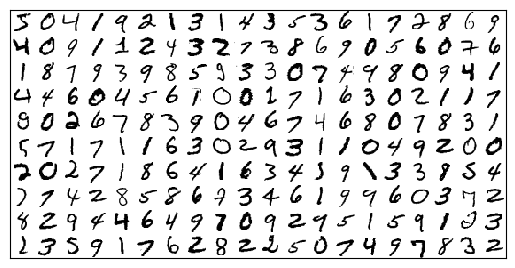

In [15]:
m, n = 10, 20
sz = np.array((28 ,28)) 
M = montage(df.iloc[:,:-1], m, n, sz)
plt.imshow(M, cmap=plt.cm.gray_r , interpolation='nearest')
plt.xticks ([]), plt.yticks ([])
plt.show()

## 隨機抽取不同手寫數字
以下將分別進行兩次相同的程式碼，讓讀者觀察兩次隨機抽取的內容不進相同

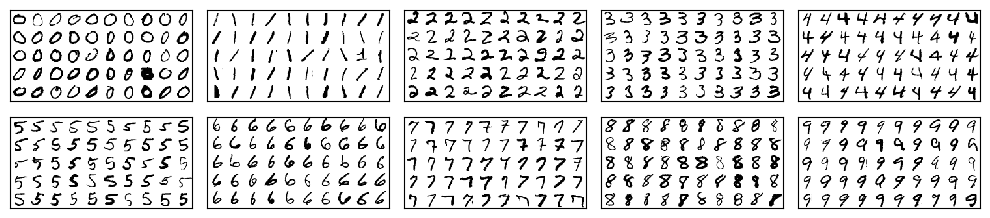

In [16]:
m = 5; n = 10
fig, axs = plt.subplots(2, 5, figsize=(10,2.5))
for e, num in enumerate(set(df['anser'])):
    sample_idx = df.index[df['anser']==num]
    want_idx = np.random.choice(sample_idx, replace=False, size=m*n) 
    A = X.loc[want_idx,:]
    M = montage(A, m, n, sz)
    ax = axs[e//5, e%5]
    ax.imshow(M, cmap=plt.cm.gray_r , interpolation='nearest')
    ax.set_xticks ([]), ax.set_yticks ([])
plt.tight_layout()
plt.show()

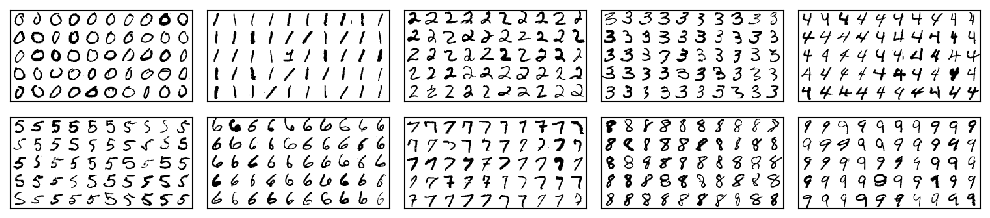

In [17]:
m = 5; n = 10
fig, axs = plt.subplots(2, 5, figsize=(10,2.5))
for e, num in enumerate(set(df['anser'])):
    sample_idx = df.index[df['anser']==num]
    want_idx = np.random.choice(sample_idx, replace=False, size=m*n) 
    A = X.loc[want_idx,:]
    M = montage(A, m, n, sz)
    ax = axs[e//5, e%5]
    ax.imshow(M, cmap=plt.cm.gray_r , interpolation='nearest')
    ax.set_xticks ([]), ax.set_yticks ([])
plt.tight_layout()
plt.show()

# 習題 3：手寫數字影像壓縮
每張大小 28×28 的手寫數字圖像 70000 張，不經壓縮前的儲存空間為 54.88 M Bytes。若進行 SVD 的 「Rank q approximation」，則壓縮倍數由 $q$ 決定。寫一支程式，當調整 $q$ 值時，可以算出壓縮的倍數，並同時顯示原圖與壓縮後還原的圖各 50 張做為比較（任選 50 張）。另外 $q$ 的選擇可以根據 $\sigma_1, \sigma_2, \cdots,  \sigma_r$ 的「能量配置」來決定，或說決定 $q$ 之後，可以計算所採用的主成分的能量佔比，本題也可以順便列印出這個佔比。

## 進行 SVD
執行 SVD 的程式碼如下所示，主要是利用到 `numpy.linalg` 中的 `svd`指令。

In [18]:
U, S, VT = np.linalg.svd(X.T, full_matrices=False)
S = np.diag(S)

由下圖可見，不同數字在 $q=1$ 的還原影像是非常相似的，到 $q=5$ 時，各數字之間開始有些許的差異，但數字 4、7、9 還是有著相似的還原影像資料，到 $q=10$ 時就可以明顯看出個數字間的差異，但數字 4 與 9 還是很相近，最後看到 $q=50$，所有數字都可以觀察到差異了，但同時也可以觀察到筆跡的差異。

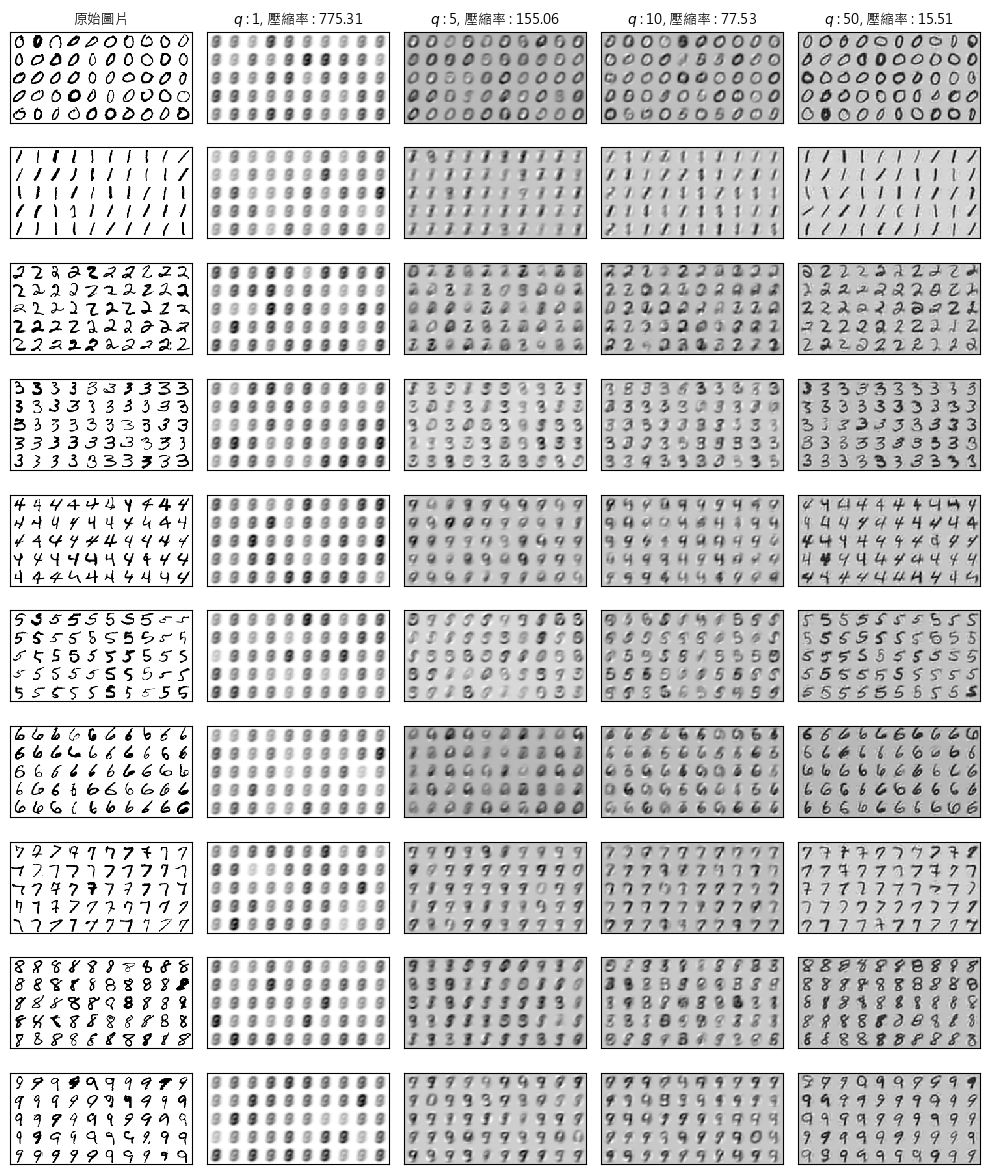

In [26]:
m = 5; n = 10
fig, axs = plt.subplots(10, 5, figsize=(10,12), sharex=True)
p, N = X.T.shape
for e_q, q in enumerate([0, 1, 5, 10, 50]):
    if q==0:
        X_q = np.array(X)
        title = "原始圖片"
    else:
        # 還原影像，計算壓縮率
        X_q = U[:,:q] @ S[:q,:q] @ VT[:q,:]
        X_q = X_q.T
        compress = np.round((p*N)/(q*(p+N + 1)),2)
        ratio = np.round(np.diagonal(S)[:q].sum()*100/np.diagonal(S).sum(),2)
        title = r"$q$ : {}, 壓縮率 : {}".format(q, compress)
    
    # 顯示原始的圖片
    for e, num in enumerate(set(df['anser'])):
        sample_idx = df.index[df['anser']==num]
        want_idx = np.random.choice(sample_idx, replace=False, size=m*n) 
        
        A = X_q[want_idx,:]
        M = montage(A, m, n, sz)
        ax = axs[e, e_q]
        ax.imshow(M, cmap=plt.cm.gray_r , interpolation='nearest')
        ax.set_xticks([]), ax.set_yticks([]), 
        if e==0:
            ax.set_title(title, fontname="Microsoft JhengHei", fontsize=10)
plt.tight_layout()
plt.show()

下圖為參照 PCA 所繪製的帕雷托圖（Pareto Plot）

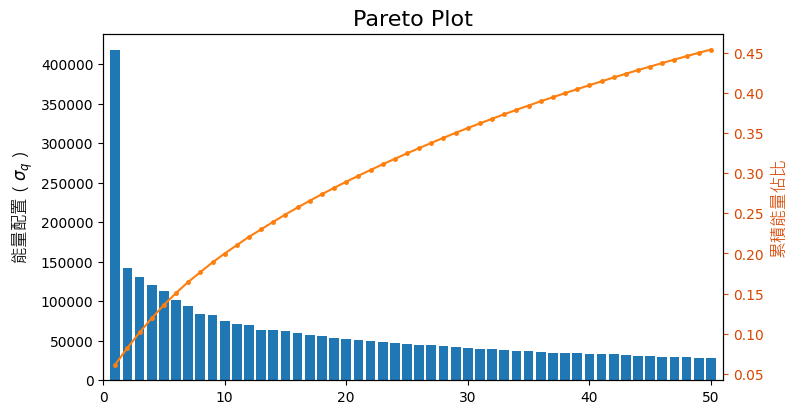

In [27]:
fig, ax = plt.subplots(1,1, figsize=(8,4.5))
x = np.arange(q)+1
ax.bar(x, np.diagonal(S)[:q])
# ax.set_xlabel('Component Number', fontsize=12)
ax.set_ylabel(r'能量配置（$\sigma_q$）', fontsize=12, fontname="Microsoft JhengHei")
ax.set_title('Pareto Plot', fontsize=16)
ax2 = ax.twinx()
ax2.plot(x, np.diagonal(S)[:q].cumsum()/np.diagonal(S).sum(), marker='o', color='C1', markersize=2.5, linestyle='-')
ax2.tick_params(axis='y', colors='#D94600')
ax2.set_ylabel('累積能量佔比', fontsize=12, color="#D94600", fontname="Microsoft JhengHei")
plt.xlim(0,q+1)
plt.show()

# 習題 4：影像加密解密

影像加密，就是將影像與奇異值分解的矩陣相乘，即可得到加密後的影像，反之若要解密，就需要乘上反矩陣進行解密

從 SVD 的數學式中可以延伸出：

\begin{align}
\mathbf{U}^T_q\mathbf{X} &= \Sigma_q\mathbf{V}^T_q = \mathbf{Z}_q = \begin{bmatrix}z_{1,q}, z_{2,q}, z_{3,q}, \ldots, z_{n,q}\end{bmatrix}\\
\rightarrow\mathbf{U}_q\mathbf{U}^T_q\mathbf{X} &= \mathbf{U}_q\mathbf{Z}_q\label{eq:Xq}
\end{align}

其中 $\mathbf{U}_q$ 代表新的座標，而 $\mathbf{Z}_q$ 代表新的座標空間的座標值。上式中的 $\mathbf{X}$ 其實是 $\mathbf{X}_q$，是影像經過加密後再進行解密的結果，並不是原始的 $\mathbf{X}$，在經過轉換後還是有一定的損失，這之中的損失過程就是壓縮或加密的原理。

In [59]:
import scipy.io
D = scipy.io.loadmat(imgfile + r'\allFaces.mat')
X = pd.DataFrame(D['faces'].T) # each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = int(D['m'])
n = int(D['n'])
n_persons = int(D['person'])

顯示出每個人的第一張圖片

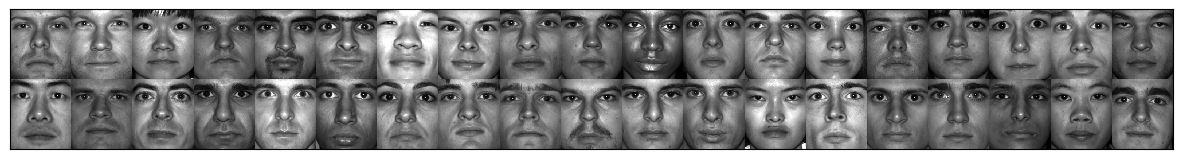

In [29]:
m, n = 19,2
sz = np.array((192, 168)) 
plt.figure(figsize=(15,15))
M = montage(X.loc[np.pad(y.cumsum()[:-1],(1,0)),:], m, n, sz[::-1]).T
plt.imshow(M, cmap=plt.cm.gray , interpolation='nearest')
plt.xticks ([]), plt.yticks ([])
plt.show()

## 解密 5 張影像
有 5 張經過加密的影像圖（壓縮檔下載），其加密的方式採 Yale Faces 38 人 2410 張人臉圖像矩陣 $X$ 的 SVD，即 $X = U\Sigma V^T$，取 $U$ 作為影像加密的工具，即假設向量 $x$ 代表一張原圖影像，則 $U[:, 0:q]^T x$ 代表該影像的前 $q$ 個主成分，以此作為加密影像。

請解密這 5 張影像。

In [35]:
encode_data = pd.read_csv(imgfile + r'\五張加密的影像.csv')

### 使用原圖執行 SVD

In [47]:
U, S, VT = np.linalg.svd(X.T, full_matrices=False)

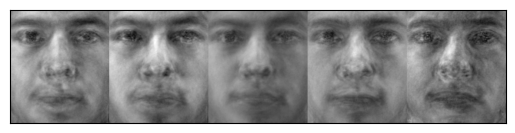

In [48]:
q = 2000
Uq = U[:, :q]
Xq = Uq @ np.array(encode_data)
M = montage(pd.DataFrame(Xq.T), 5, 1, sz[::-1])
plt.imshow(M.T, cmap=plt.cm.gray)
plt.xticks([]);plt.yticks([])
plt.show()

### 原始影像減去平均

In [60]:
avg_img = np.tile(np.array(X.T.mean(axis=1)).reshape(-1,1), X.shape[0])
X_avg = np.array(X.T) - avg_img

In [61]:
U, S, VT = np.linalg.svd(X_avg, full_matrices=False)

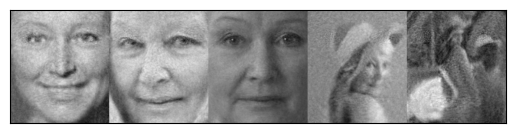

In [44]:
q = 2000
Uq = U[:, :q]
Xq = Uq @ np.array(encode_data)
M = montage(pd.DataFrame(Xq.T), 5, 1, sz[::-1])
plt.imshow(M.T, cmap=plt.cm.gray)
plt.xticks([]);plt.yticks([])
plt.show()

## 自行找 5 張照片進行加密解密
自行找 5 張照片（大小必須同 Yale Faces 的 192×168 或自行 Resize），含人臉、水果、風景 … 等進行加密後（q 自選），再解密，觀察這些解密後的影像的效果，是否人臉的表現比較好？其他非人臉影像，如風景影像，能透過由人臉建構的特徵 U 加密嗎？（即解密後能否看到原圖模樣？）

In [68]:
five_img = np.zeros((192*168,5))
files = glob.glob(r'C:\Course\1112ShallowMachineLearning\hw2SVD_Image\img\*')
for e,file in enumerate(files):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img_res = cv2.resize(img, dsize=(192, 168), interpolation=cv2.INTER_CUBIC)
    five_img[:,e] = img_res.reshape(1,-1)

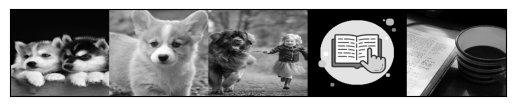

In [77]:
M = montage(five_img.T, 1,5, sz[::-1])
plt.imshow(M, cmap=plt.cm.gray)
plt.xticks([]);plt.yticks([])
plt.show()

q = 100 的結果


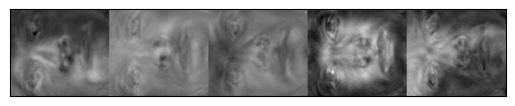

q = 500 的結果


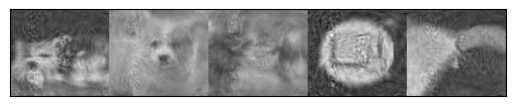

q = 700 的結果


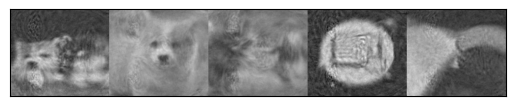

q = 1000 的結果


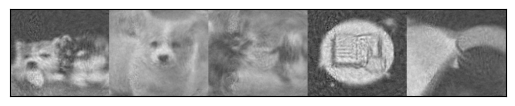

q = 1500 的結果


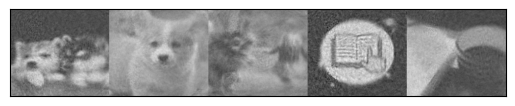

q = 2000 的結果


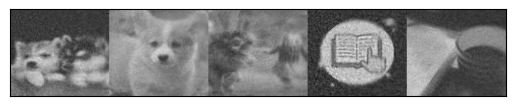

In [86]:
for q in [100,500,700,1000, 1500,2000]:
    A = U.T @ five_img
    A = A[:q,:] 
    Xq = U[:,:q] @ A
    M = montage(Xq.T, 1,5, sz[::-1])
    print(f"q = {q} 的結果")
    plt.imshow(M, cmap=plt.cm.gray)
    plt.xticks([]);plt.yticks([])
    plt.show()